In [ ]:
# Bar Plot from SRO: from plot_fate_byOilAndLocation.ipynb

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

In [62]:
plt.style.use(r'extraction_from_rachaels.template')


Bad key xtick.labelcolor in file extraction_from_rachaels.template, line 22 ('xtick.labelcolor:    inherit # color of the tick labels or inherit from xtick.color')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key ytick.labelcolor in file extraction_from_rachaels.template, line 32 ('ytick.labelcolor:    inherit # color of the tick labels or inherit from ytick.color')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution


In [19]:
MIDOSScolors={
    'ANS': 'darkslategrey',
    'Bunker-C':'teal',
    'Dilbit':'slategrey',
    'Diesel':'darkgoldenrod',
}

In [20]:
with open('SRO_files_try3_t2.yaml') as file:
    sro = yaml.safe_load(file)

In [21]:
df={}
df['ANS'] = pd.DataFrame(sro['akns'])
df['Bunker-C'] = pd.DataFrame(sro['bunker'])
df['Diesel'] = pd.DataFrame(sro['diesel'])
df['Dilbit'] = pd.DataFrame(sro['dilbit'])

oil_types = ['ANS', 'Bunker-C', 'Diesel', 'Dilbit']
locations = ['water','sfc','beach','air']

In [22]:
final = {}
initial={}
for location in locations:
    final[location]={}
    for oil in oil_types:
        final[location][oil]=[]
for oil in oil_types:
    final['water'][oil] = (df[oil]['MDispersed'] + 
        df[oil]['MDissolved'] + 
        df[oil]['MBio'])
    final['sfc'][oil] = df[oil]['MassOil']
    final['beach'][oil] = df[oil]['MBeached']
    final['air'][oil] = df[oil]['MEvaporated']
    initial[oil]=df[oil]['MInitial']

In [23]:
persist = {}

# Calculate Quantiles
persist['Q1']={}
persist['Q2']={}
persist['Q3']={}
for oil in ['ANS','Bunker-C','Diesel']:
    persist['Q1'][oil]={}
    persist['Q2'][oil]={}
    persist['Q3'][oil]={}
    for loc in locations:
        #Quantile 0.25 (in percent form)
        persist['Q1'][oil][loc]=100*np.quantile(
            final[loc][oil]/(initial[oil]), .25)
        #Quantile 0.5 (median, in percent form)
        persist['Q2'][oil][loc]=100*np.quantile(
            final[loc][oil]/(initial[oil]), .50)
        #Quantile 0.75 (in percent form)
        persist['Q3'][oil][loc]=100*np.quantile(
            final[loc][oil]/(initial[oil]), .75)
        
persist_df = {}
for opp in ['Q1','Q2','Q3']:
    persist_df[opp] = pd.DataFrame({
        "ANS":[persist[opp]["ANS"]["water"], persist[opp]["ANS"]["sfc"], persist[opp]["ANS"]["beach"], persist[opp]["ANS"]["air"]],
        "Bunker-C":[persist[opp]["Bunker-C"]["water"], persist[opp]["Bunker-C"]["sfc"], persist[opp]["Bunker-C"]["beach"], persist[opp]["Bunker-C"]["air"]],
        "Diesel":[persist[opp]["Diesel"]["water"], persist[opp]["Diesel"]["sfc"], persist[opp]["Diesel"]["beach"], persist[opp]["Diesel"]["air"]]
        }, 
        index=["water", "surface", "beach", "air"]
    )
    persist_df[opp] = persist_df[opp].rename_axis(opp, axis=1)

In [50]:
error_minxx = persist_df['Q2'] - persist_df['Q1']
error_maxxx = persist_df['Q3'] - persist_df['Q2']
print (error_minxx)
print (error_minxx.to_numpy())

Q2             ANS   Bunker-C     Diesel
water     0.021132   0.000078   0.049216
surface   0.636309   0.341071   0.066490
beach    18.150134  11.264523  16.996533
air       1.693576   1.163776   8.503893
[[2.11317052e-02 7.76002149e-05 4.92162097e-02]
 [6.36309089e-01 3.41070740e-01 6.64895907e-02]
 [1.81501341e+01 1.12645232e+01 1.69965332e+01]
 [1.69357583e+00 1.16377621e+00 8.50389329e+00]]


In [57]:
yerr_reorg = np.zeros((6, 4))
for ii in range(0, 6, 2):
    jj = int(ii/2)
    yerr_reorg[ii] = error_minxx.to_numpy()[:,jj]
    yerr_reorg[ii+1] = error_maxxx.to_numpy()[:,jj]
print(yerr_reorg)

[[2.11317052e-02 6.36309089e-01 1.81501341e+01 1.69357583e+00]
 [2.50453882e-01 7.58300837e+00 3.39583924e+00 1.28769846e+00]
 [7.76002149e-05 3.41070740e-01 1.12645232e+01 1.16377621e+00]
 [2.38240787e-03 5.61651883e+00 3.37988162e+00 3.26644017e+00]
 [4.92162097e-02 6.64895907e-02 1.69965332e+01 8.50389329e+00]
 [1.29953371e+00 5.53670112e-01 9.77984958e+00 1.12220080e+01]]


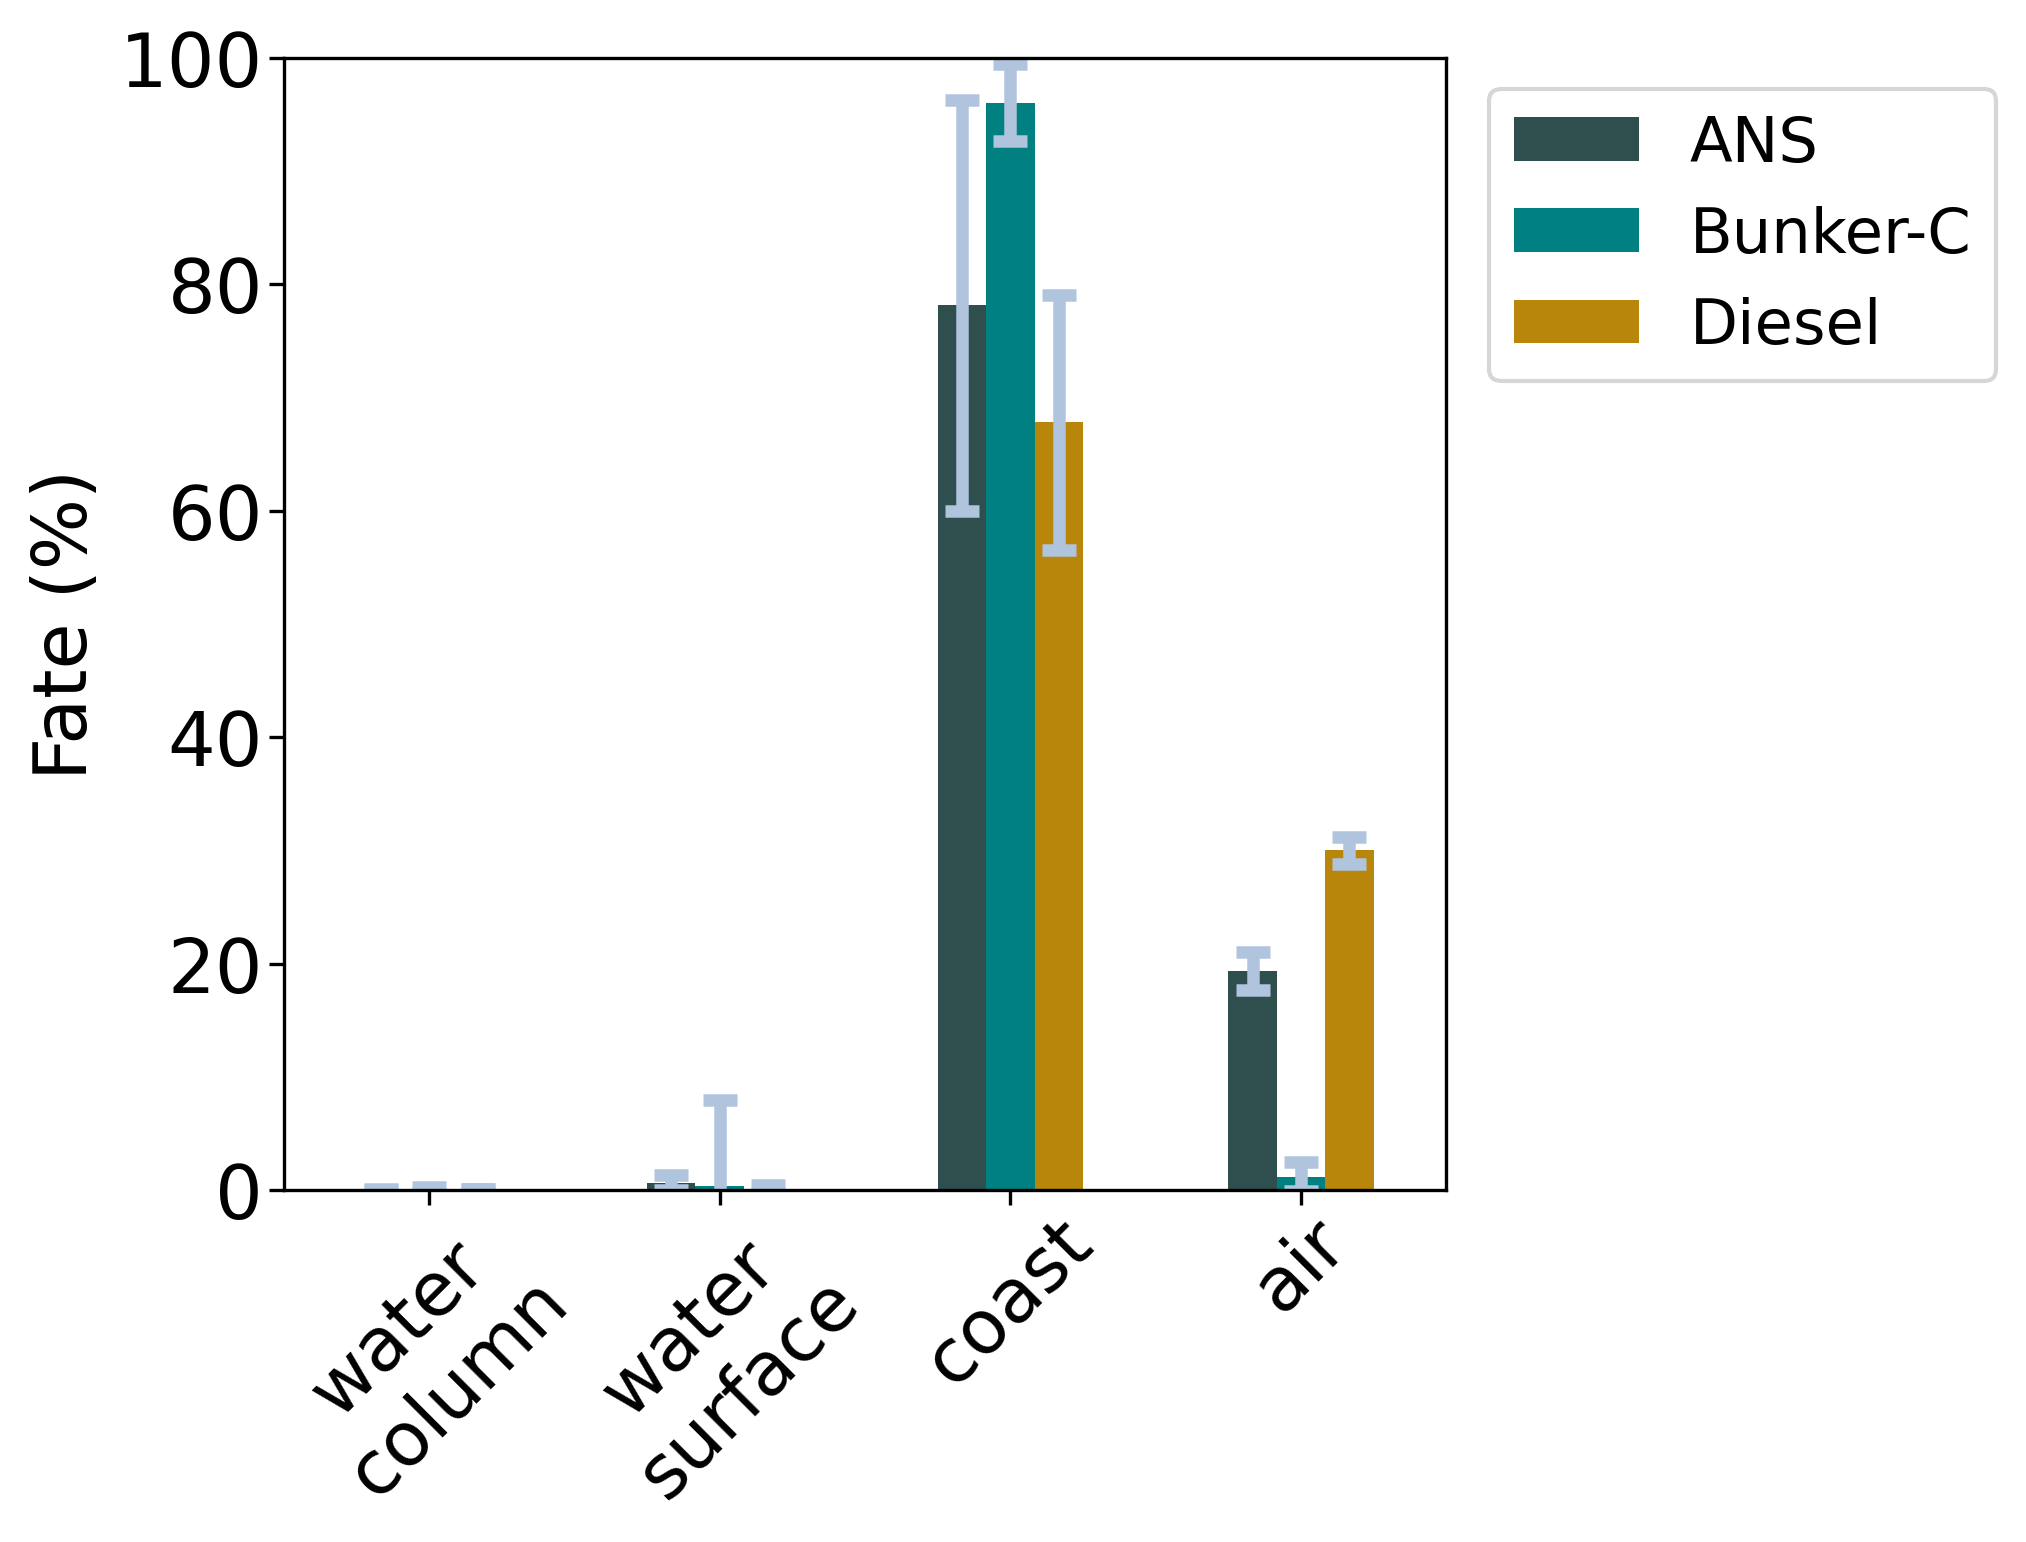

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
persist_df['Q2'].plot(ax=ax,
    kind="bar",
    color=[MIDOSScolors["ANS"],MIDOSScolors["Bunker-C"],MIDOSScolors["Diesel"]],
    legend=False,          
    yerr=yerr_reorg, #np.append(error_max, error_min, axis=0), 
    error_kw=dict(lw=3, capsize=4, capthick=3),
    ecolor='lightsteelblue'
)
ax.set_ylabel("Fate (%)")
ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right')
ax.set_ylim(0,100)
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels(
    ["water\ncolumn", "water\nsurface", "coast", "air"],
    rotation=45
)

plt.savefig('Fate_ByOilLocation_1panel_MedianErr.png')

In [ ]:
# For Jose

In [ ]:
from salishsea_tools import river_201702